In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import sys
import os

# Add the parent directory to the path so we can import the module
sys.path.append(os.path.abspath(os.path.join('..')))

In [24]:
from modules.needleman_wunsch import *

Alignment was made with Needleman-Wunsch algorithm. Score is 15.
Alignments:
ABCDG-GH-H
ABCDEFGHHR


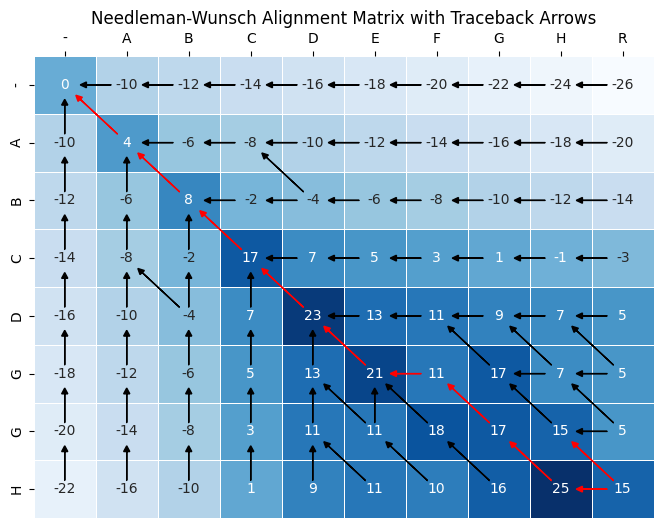

In [46]:
seq1='ABCDGGH'
seq2='ABCDEFGHR'
identity_score=1
substitution_score=-1
gap_opening_score=-10
gap_extension_score = -2

score, alignements = needleman_wunsch([seq1, seq2], True, gap_opening_score, gap_extension_score, True)

In [49]:
from tests.test_needleman_wunsch import *

Running tests for score_i_j_alignment_multidim...
All tests passed for score_i_j_alignment_multidim 

Running tests for needleman_wunsch_basic...
Alignments:
ACGT
A-GT
All tests passed for needleman_wunsch_basic 

Running tests for needleman_wunsch_vs_biopython...
Alignments:
ACGT
A-GT
Biopython alignment is: 
ACGT
A-GT
All tests passed for needleman_wunsch_vs_biopython 

Running tests for needleman_wunsch_vs_biopython_blossum...
Alignments:
ACGT
A-GT
Biopython alignment is: 
ACGT
A-GT
All tests passed for needleman_wunsch_vs_biopython_blossum 



In [56]:
# let's try to fill matrice to align sequence with all other sequences aligned between them
def fill_needleman_wunsch_matrix_multidim(sequence, previous_alignment, blosum_m, gap_opening_score, gap_extension_score, identity_score=1, substitution_score=-1):
    '''
    Fill the Needleman-Wunsch matrix and store the indexes of the arrows with possibility to have up to 3 arrows.

    Parameters:
    ----------
    sequence :  str
        Sequences to align with the previous alignment.
    previous_alignment : list of str
        Some sequences already aligned.
    blosum_m : bool
        If True, we use BLOSUM62 matrix.
    gap_opening_score : int
        Score for opening a gap.
    gap_extension_score : int
        Score for extending a gap.
    identity_score : int
        Score for aligning identical characters.
    substitution_score : int
        Score for aligning non-identical characters.

    Returns:
    -------
    matrix : pandas.DataFrame
        The filled matrix.
    '''
    # Initialize the matrix
    rows = len(sequence) + 1
    cols = len(previous_alignment[0]) + 1

    matrix = pandas.DataFrame(index=range(rows), columns=range(cols))
    arrow_matrix = pandas.DataFrame(index=range(rows), columns=range(cols))
    gap_matrix = pandas.DataFrame(index=range(rows), columns=range(cols))

    arrow_matrix.at[0, 0] = None
    matrix.at[0, 0] = 0
    gap_matrix.at[0, 0] = 0
 

    # Initialize the first row and column
    for i in range(1, rows):
        matrix.at[i, 0] = gap_opening_score + (i-1) * gap_extension_score
        arrow_matrix.at[i, 0] = [(i-1, 0)]
        gap_matrix.at[i, 0] = 1
    for j in range(1, cols):
        matrix.at[0, j] = gap_opening_score + (j-1) * gap_extension_score
        arrow_matrix.at[0, j] = [(0, j-1)]
        gap_matrix.at[0, j] = 1


    # Fill the matrix 
    for i in range(1, rows):
        for j in range(1, cols):
            # Calculate the scores
            chr_alignment = [previous_alignment[k][j-1] for k in range(len(previous_alignment))]
            print(chr_alignment, sequence[i-1])
            if blosum_m:
                match = matrix.at[i-1, j-1] + score_i_j_alignment_multidim(sequence[i-1], chr_alignment, blosum_m)
            else:
                match = matrix.at[i-1, j-1] + score_i_j_alignment_multidim(sequence[i-1], chr_alignment, blosum_m, identity_score, substitution_score)
            if gap_matrix.at[i-1, j] == 1:
                delete = matrix.at[i-1, j] + gap_extension_score
            else:
                delete = matrix.at[i-1, j] + gap_opening_score
            if gap_matrix.at[i, j-1] == 1:
                insert = matrix.at[i, j-1] + gap_extension_score
            else:
                insert = matrix.at[i, j-1] + gap_opening_score

            # Update the matrix
            max_score = max(match, delete, insert)
            arrow_matrix.at[i, j] = []
            matrix.at[i, j] = max_score
            if max_score == match:
                arrow_matrix.at[i, j].append((i-1, j-1))
                gap_matrix.at[i, j] = 0
            if max_score == delete:
                arrow_matrix.at[i, j].append((i-1, j))
                gap_matrix.at[i, j] = 1
            if max_score == insert:
                arrow_matrix.at[i, j].append((i, j-1))
                gap_matrix.at[i, j] = 1

    return matrix, arrow_matrix

In [65]:
def plot_nw_matrix_multidim(matrix, arrow_matrix, sequences):
    """
    Visualize the Needleman-Wunsch matrix with arrows.

    Parameters:
    ----------
    matrix : pandas.DataFrame
        The filled matrix with scores.
    arrow_matrix : pandas.DataFrame
        The matrix of arrows indicating traceback paths.
    sequences : list of str
        List of sequences to align. Sequences[0] is the sequence on the vertical axis, and Sequences[1], Sequences[2], etc is the sequence on the horizontal axis.
    """
    print(sequences)
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Convert matrix to numpy array, replacing None with 0
    matrix_np = matrix.fillna(0).to_numpy()
    
    # Define labels for the axes (insert '-' at the beginning to account for initial gap)
    row_labels = ['-'] + list(sequences[0])
    col_labels = ['-'] + list(sequences[1])

    for i in range(1, len(col_labels)):
        for j in range(2, len(sequences)):
            col_labels[i] = col_labels[i] + '\n' + sequences[j][i-1]
    
    # Create a heatmap with custom labels
    sns.heatmap(matrix_np.astype(float), annot=True, fmt=".0f", cmap="Blues", linewidths=0.5, 
                ax=ax, cbar=False, xticklabels=col_labels, yticklabels=row_labels)
    
    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")

    #traceback index[0] = n, m
    traceback_indexes = [(matrix.shape[0]-1, matrix.shape[1]-1)]
    while traceback_indexes[-1] != (0, 0):
        for prev_i, prev_j in arrow_matrix.at[traceback_indexes[-1][0], traceback_indexes[-1][1]]:
            traceback_indexes.append((prev_i, prev_j))

    # Draw arrows based on arrow_matrix
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if arrow_matrix.at[i, j] is not None:
                for prev_i, prev_j in arrow_matrix.at[i, j]:
                    dx = prev_j - j  # X direction
                    dy = prev_i - i  # Y direction

                    # color is red if arrow is in traceback_indexes
                    if ((prev_i, prev_j) in traceback_indexes and (i, j) in traceback_indexes):
                        color = 'red'
                    else:
                        color = 'black'
                    if dx == 0:
                        ax.arrow(j + 0.5, i + 0.35, dx * 0.5, dy * 0.5, head_width=0.1, 
                                 head_length=0.1, fc=color, ec=color)
                    elif dy == 0:
                        ax.arrow(j + 0.25, i + 0.5, dx * 0.4, dy * 0.5, head_width=0.1, 
                                 head_length=0.1, fc=color, ec=color)
                    else:
                        ax.arrow(j + 0.35, i + 0.35, dx * 0.6, dy * 0.6, head_width=0.1, 
                             head_length=0.1, fc=color, ec=color)
    
    ax.set_title("Needleman-Wunsch Alignment Matrix with Traceback Arrows")
    plt.show()

['A', 'A'] A
['B', 'B'] A
['-', 'C'] A
['D', 'D'] A
['A', 'A'] C
['B', 'B'] C
['-', 'C'] C
['D', 'D'] C
['AC', 'AB-D', 'ABCD']


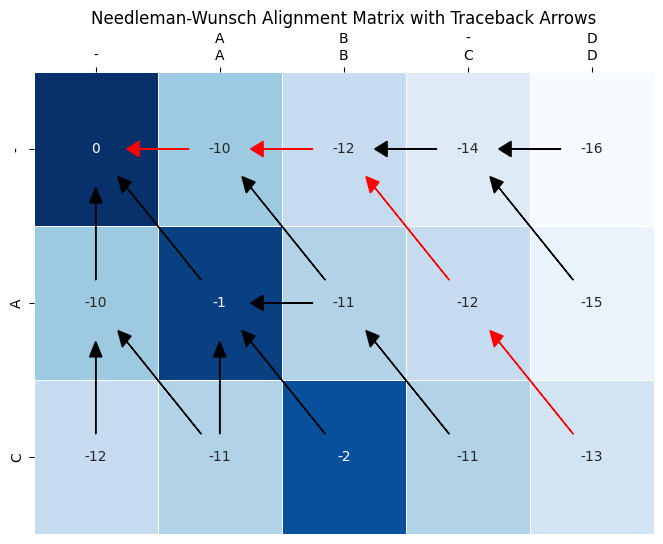

In [ ]:
seq='AC'
previous_alignment=['AB-D', 'ABCD', 'A-CD', '--C-', '-B-D', 'A-DD', 'BBC-']
identity_score=1
substitution_score=-1
gap_opening_score=-10
gap_extension_score = -2

matrix, arrow_matrix = fill_needleman_wunsch_matrix_multidim(seq, previous_alignment, False, gap_opening_score, gap_extension_score, identity_score, substitution_score)
plot_nw_matrix_multidim(matrix, arrow_matrix, [seq]+previous_alignment)